# Optimal Sampling pour la Descente de Gradient

*Author : Benjamin Pineau*

On applique ici la théorie de l'optimal sampling dans le cadre de la descente de gradient, que l'on testera sur différents projecteurs. 

On utilise la fonction perte 
$$
\mathcal{L}(v) = \frac{1}{2}\left\lVert u - v\right\rVert 
$$
où $u$ est la fonction que l'on recherche. 

In [1]:
# Importation des bibliotheques
import numpy as np
from scipy.special import legendre
from numpy.polynomial import Polynomial
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from numpy.linalg import cond
from scipy import stats
import pandas as pd
import time
from scipy.stats import norm
from scipy.stats import uniform
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from numpy.linalg import lstsq
import numpy.random as rnd
import torch
from scipy.linalg import sqrtm
import nbimporter
from scipy.integrate import quad
from scipy.optimize import minimize
from numpy.polynomial.hermite import hermgauss

## Définition des fonctions 

Dans un premier temps on définit toutes les fonctions utiles à l'application de l'optimal sampling

In [2]:
#Définition d'une base de L2(X, dp)

def base_legendre(degree, a, b):

    # INPUT : la dimension de la base de L2([-1, 1], dp)
    # OUTPUT : une base de dimension d'entrée, avec des polynomes de Legendre (sous forme de liste)

    base = []
    for j in range(degree + 1):
        coeffs = [0 for i in range(j+1)]
        if j == 0:
            coeffs = [1]
        else:
            coeffs[-1] = 1
        P_j = Legendre(coeffs, domain = [a, b])
        phi_j = np.sqrt((2*j + 1)/2)*P_j
        base.append(phi_j.convert(domain = [a, b], kind=Legendre))

    return base

In [3]:
# Définition de la mesure pour l'échantillonage optimal

def density_phi1(x, rho, base, m):

    # INPUT : un vecteur de données x, une densité rho, une base (sous forme de liste de polynomes), la taille de la base 
    # OUTPUT : un vecteur qui suit la loi d'une certaine densité (cf rapport)

    phi1 = rho * sum( (1/m * (base[i](x))**2 ) for i in range(m))
    return phi1

In [4]:
# Fonction que l'on cherche à approximer

def fonction_recherchee(x):

    # INPUT : un vecteur de données x
    # OUTPUT : la fonction que l'on cherche à estimer évaluée en x
    
    return np.exp(x)

In [5]:
# Fonction perte utilisée pour la descente de gradient

def L(u, v):

    # INPUT : deux fonction u et v 
    # OUTPUT : fonction perte entre u et v 
    
    return 1/2*np.linalg.norm(u - v)**2

In [6]:
# Gradient de la fonction perte. 
# On peut également appliquer une backpropagation sur Pytorch par exemple lorsque l'on ne connais pas l'expression analytique

def grad_L(u, v):
    
    # INPUT : deux fonction u et v 
    # OUTPUT : gradient de la fonction perte entre u et v 
    
    return -(u - v)

In [7]:
# Définition des fonctions pour évaluer la fonction de Christoffel généralisée

def R_tilde(x, base_t):

    # INPUT : 
    # OUTPUT :
    
    d_t = len(base_t)
    return [sum((np.linalg.norm(base_t[k](x[i]))**2) for k in range(d_t)) for i in range(len(x))]


def norm_L1_R_tilde(base_t):

    # INPUT : 
    # OUTPUT :
    
    loi_uniform = stats.uniform(loc = -1, scale = 2)
    integral, _ = quad(lambda u: R_tilde([u], base_t)[0], -1, 1)
    return integral


def compute_w_t(x, base_t):

    # INPUT : 
    # OUTPUT :
    
    R_tilde_val = R_tilde(x, base_t)
    norm_R_tilde = norm_L1_R_tilde(base_t)
    w = [norm_R_tilde/R_tilde_val[i] for i in range(len(x))]
    return w


In [8]:
# Calcul de la matrice de Gram pour le produit scalaire discret

def matrice_gram(x, base_t):
        
    # INPUT : un vecteur de données, une base sous forme de liste de polynome de Legendre
    # OUTPUT : une matrice de Gram associée à la base évaluée en x
    
    m = len(base_t)
    G = np.zeros((m, m))
    w = compute_w_t(x, base_t)
    for i, phi_i in enumerate(base_t):
        for j, phi_j in enumerate(base_t):
            G[i, j] = produit_scalaire_n(base_t[i](x), base_t[j](x), w)
    return G

In [9]:
# Définition du produit scalaire discret

def produit_scalaire_n(u, v, w):

    # INPUT : 2 fonctions, une liste de poids, un vecteur de données
    # OUTPUT : le produit scalaire des 2 fonctions u et v évalués en x

    n = len(w)
    ps = 1/n* sum( (w[i] * u[i] * v[i]) for i in range(n))
    return ps

In [10]:
# Sampling de n réalisation selon la mesure optimal par discrétisation

def sequential_conditional_sampling_discretisation(n, m, base, a, b):

    # INPUT : la taille de l'échantillon à creer, la taille de la base, une base sous forme de liste de polynome de Legendre
    # OUTPUT : n échantillons de la loi décrite dans le rapport générer par la méthode du rejet
    
    loi_uniform = stats.uniform(loc = a, scale = b - a)
    t = np.linspace(a, b, 1000)
    dt = (b - a)/1000
    densite_phi = density_phi1(t, loi_uniform.pdf(t), base, m)
    proba_discrete = densite_phi*dt
    proba_discrete = proba_discrete/(sum(proba_discrete))

    index_samples = rnd.choice(a = len(t), p = proba_discrete, size = n)
    samples = t[index_samples]
    
    return np.array(samples)

On va tester deux types de projection :

La unbiased quasi projection 
$$
P_t^ng_t = \sum_{k = 1}^{d_t}\hat{\eta}_k b_k \quad \text{avec} \quad \hat{\eta}_k = (g_t, b_k)_n
$$
et la least-squared projection
$$
P_t^ng_t = \sum_{k = 1}^{d_t} \hat{\hat{\eta}}b_k \quad \text{avec} \quad \hat{\hat{\eta}} = \hat{G}^+\hat{\eta}
$$
où $g_t$ est le gradient à l'étape $t$, $G$ la matrice de Gram et $(b_k)_k$ une base orthonormée de $\mathcal{T}_t$

In [11]:
# Définition de la unbiaised quasi projection 

def quasi_proj(x, base_t, u_t):

    # INPUT : un vecteur x, une base orthonormée et l'itération à l'instant t de u_t
    # OUTPUT : une unbiaised quasi projection sur T_t du gradient de la fonction perte, évalué en x
    
    d_t = len(base_t)
    return sum((base_t[k](x) * produit_scalaire_n(base_t[k](x), grad_L(fonction_recherchee(x), u_t(x)), compute_w_t(x, base_t))) for k in range(d_t))

In [12]:
# Définition de la least-squares projection

def ls_proj(x, base_t, u_t):

    # INPUT : un vecteur x, une base orthonormée et l'itération à l'instant t de u_t
    # OUTPUT : une least-squared projection sur T_t du gradient de la fonction perte, évalué en x
    
    d_t = len(base_t)
    G = matrice_gram(x, base_t)
    G_pseudo_inv = sqrtm(np.linalg.pinv(G))
    eta = [produit_scalaire_n(base_t[k](x), grad_L(fonction_recherchee(x), u_t(x)), compute_w_t(x, base_t)) for k in range(d_t)]
    return sum( (base_t[k](x)*(G_pseudo_inv@eta)[k] ) for k in range(d_t) )


In [13]:
# Calcul du vecteur d tel que Gv = d 
# G = matrice de Gram
# v = vecteur des évaluations d'une fonction u (par exemple celle que l'on cherche à approcher)
# Ici on utilise l'optimal sampling

def calcul_data_vector_os(x, base, w, y):

    # INPUT : un vecteur de données, la base sous forme de liste de polynome de Legendre, une liste de poids, un vecteur d'observation
    # OUTPUT : data vector avec optimal sampling (cf rapport)
    
    n = len(x)
    m = len(base)
    data_vector = np.zeros(m)
    for j in range(m):
        data_vector[j] = 1/n*sum((w[i]*y[i]*base[j](x[i])) for i in range(n))
    
    return data_vector

In [14]:
# Calcul du vecteur d tel que Gv = d 
# G = matrice de Gram
# v = vecteur des évaluations d'une fonction u (par exemple celle que l'on cherche à approcher)
# Ici on utilise des points pris uniformément sur un segment

def calcul_data_vector_unif(x, base, y):

    # INPUT : un vecteur de données, la base sous forme de liste de polynome de Legendre, une liste de poids, un vecteur d'observation
    # OUTPUT : data vector avec répartition uniforme
    
    n = len(x)
    m = len(base)
    data_vector = np.zeros(m)
    for j in range(m):
        data_vector[j] = 1/n*sum((y[i]*base[j](x[i])) for i in range(n))
    
    return data_vector

In [15]:
# Calcul de la projection avec optimal sampling

def calcul_proj_os(n_vect, m_base, a, b, u_t, proj, delta):

    # INPUT : le nombre d'échantillon n, la dimension de la base, [a, b] l'intervalle d'étude, 
    #       l'itération à l'instant t de u_t, le type de projection choisi, 
    #       un seuil d'acceptation pour la least-squared projection
    # OUTPUT : une fonction polynomiale qui approche la projection choisie grâce à de l'optimal sampling
    
    base_t = base_legendre(m_base - 1, a, b)

    # projection AVEC optimal sampling
    x_samples = sequential_conditional_sampling_discretisation(n_vect, m_base, base_t, a, b)
    G = matrice_gram(x_samples, base_t)

    # seuil d'acceptation (cf rapport)
    if proj == 'ls_proj' or proj == 'quasi_proj':
        Id = np.eye(len(base_t))
        while np.linalg.norm(Id - G) > delta:
            x_samples = sequential_conditional_sampling_discretisation(n_vect, m_base, base_t, a, b)
            G = matrice_gram(x_samples, base_t) 

    poids = compute_w_t(x_samples, base_t)

    # calcul du projection que l'on cherche à approcher
    if proj == 'quasi_proj':
        y = quasi_proj(x_samples, base_t, u_t)
    elif proj == 'ls_proj':
        y = ls_proj(x_samples, base_t, u_t)

    
    d = calcul_data_vector_os(x_samples, base_t, poids, y)

    # résolution du système linéaire
    v = np.dot(np.linalg.inv(G), d)
    v_norm = np.array([v_k*np.sqrt((2*k + 1) / 2) for k, v_k in enumerate(v)])
    v_Legendre = Legendre(v_norm, domain = [a, b])

    return v_Legendre

In [16]:
# Calcul de la projection avec uniform sampling

def calcul_proj_unif(n_vect, m_base, a, b, u_t, proj):

    # INPUT : le nombre d'échantillon n, la dimension de la base, [a, b] l'intervalle d'étude, 
    #       l'itération à l'instant t de u_t, le type de projection choisi, 
    #       un seuil d'acceptation pour la least-squared projection
    # OUTPUT : une fonction polynomiale qui approche la projection choisie grâce à un sampling uniforme
    
    base_t = base_legendre(m_base - 1, a, b)

    # projection SANS optimal sampling

    # calcul du projection que l'on cherche à approcher
    x_unif = np.linspace(-1, 1, n_vect)
    if proj == 'quasi_proj':
        y_unif = quasi_proj(x_unif, base_t, u_t)
    elif proj == 'ls_proj':
        y_unif = ls_proj(x_unif, base_t, u_t)
    

    # résolution du système linéaire
    G_unif = matrice_gram(x_unif, base_t)
    d_unif = calcul_data_vector_unif(x_unif, base_t, y_unif)

    v_unif = np.dot(np.linalg.inv(G_unif), d_unif)
    v_norm_unif = np.array([v_k*np.sqrt((2*k + 1) / 2) for k, v_k in enumerate(v_unif)])
    v_Legendre_unif = Legendre(v_norm_unif, domain = [a, b])

    return v_Legendre_unif

## Application globale de la théorie de l'optimal sampling pour la descente de gradient

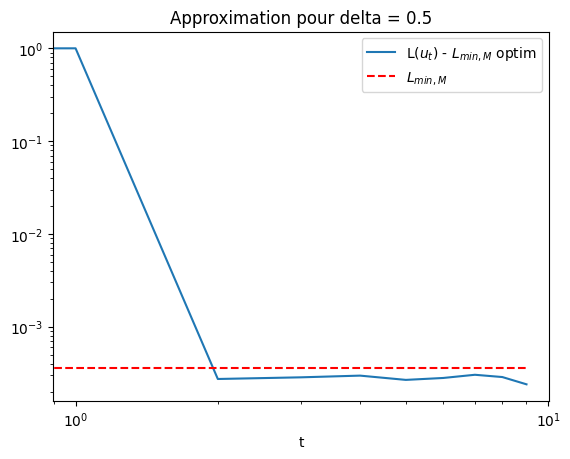

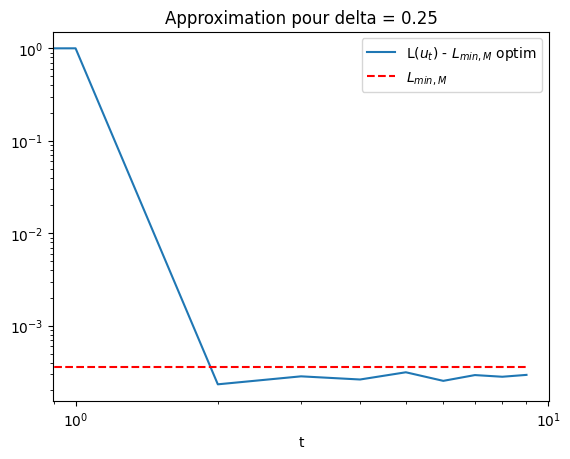

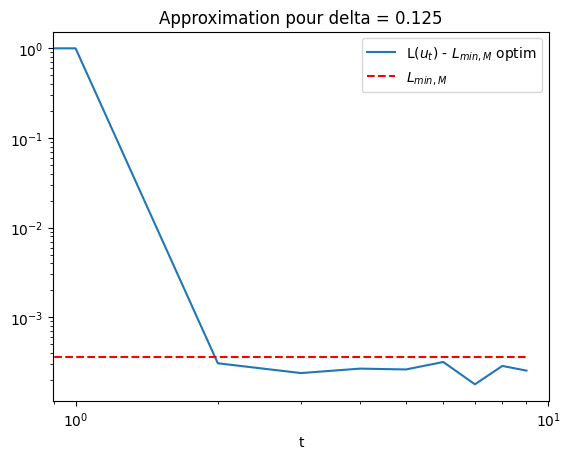

In [19]:
# Application globale de la théorie de l'optimal sampling

# paramètres
a, b = -1, 1    # intervale [a, b] d'étude
u_t = Legendre([1 for i in range(3)], domain = [a, b])      # initialisation de u_t pour l'optimal sampling
u_t_unif = Legendre([1 for i in range(3)], domain = [a, b])     # initialisation de u_t pour le sampling uniform
n_vect = 10    # nombre de point à sampler
m_base = 4      # taille de la base V_m
step_size = 1   # step size 

liste_error_unif = [] 
L_min = 3.6*10**(-4)
nb_iter_ut = 10
int_t = [2/9*1/(t+1)**0.9 for t in range(nb_iter_ut)]
proj = 'ls_proj'    # type de projection utilisée 
liste_delta = [1/2, 1/4, 1/8]

for delta in liste_delta:
    liste_error = []
    for t in range(nb_iter_ut):
        # calcul de la projection souhaité
        base_t = base_legendre(m_base, a, b)
        projection = calcul_proj_os(n_vect, m_base, a, b, u_t, proj, delta)

        # descente de gradient
        u_t = u_t - step_size*projection
        x_os = sequential_conditional_sampling_discretisation(n_vect, m_base, base_t, a, b)
        L_estim = L(u_t(x_os), fonction_recherchee(x_os))
        liste_error.append(np.abs(L_estim - L_min))

    liste_error[1] = 1

    plt.loglog([t for t in range(nb_iter_ut)], liste_error, label = 'L($u_t$) - $L_{min,M}$ optim')
    plt.loglog([t for t in range(nb_iter_ut)], [L_min for t in range(nb_iter_ut)], '--', label = '$L_{min,M}$', color = 'red')
    plt.legend()
    plt.title(f'Approximation pour delta = {delta}')
    plt.xlabel('t')
    plt.show()

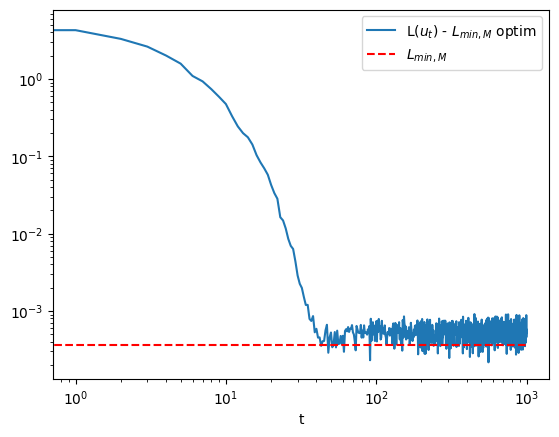

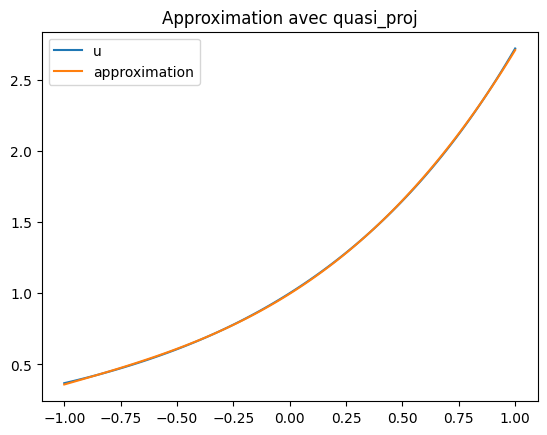

In [ ]:
# Application globale de la théorie de l'optimal sampling

# paramètres
a, b = -1, 1    # intervale [a, b] d'étude
u_t = Legendre([1 for i in range(3)], domain = [a, b])      # initialisation de u_t pour l'optimal sampling
u_t_unif = Legendre([1 for i in range(3)], domain = [a, b]) # initialisation de u_t pour le sampling uniform
n_vect = 100    # nombre de point à sampler
m_base = 4      # taille de la base V_m
step_size = 1/9 # step size 
liste_error = []
liste_error_unif = []
L_min = 3.6*10**(-4)
nb_iter_ut = 1000
# liste de step size pour le faire varier durant la descente de gradient
step_size_var = [2/9*(1/(t+1))**0.9 for t in range(nb_iter_ut)] 
for i in range(10):
    step_size_var[i] = 1


proj = 'quasi_proj' # type de projection utilisée 


for t in range(nb_iter_ut):
    # calcul de la projection souhaité
    base_t = base_legendre(m_base, a, b)
    projection = calcul_proj_os(n_vect, m_base, a, b, u_t, proj, 1/4)
    projection_unif = calcul_proj_unif(n_vect, m_base, a, b, u_t, proj)

    # Etude AVEC optimal sampling
    # descente de gradient
    u_t = u_t - step_size*projection
    x_os = sequential_conditional_sampling_discretisation(n_vect, m_base, base_t, a, b)
    L_estim = L(u_t(x_os), fonction_recherchee(x_os))
    liste_error.append(np.abs(L_estim - L_min))

    # Etude SANS optimal sampling
    # descente de gradient
    u_t_unif = u_t_unif - step_size*projection_unif
    x_unif = np.linspace(-1, 1, n_vect)
    #L_estim_unif = L(u_t_unif(x_unif), fonction_recherchee(x_unif))
    liste_error_unif.append(np.abs(L_estim_unif - L_min))


plt.loglog([t for t in range(nb_iter_ut)], liste_error, label = 'L($u_t$) - $L_{min,M}$ optim')
plt.loglog([t for t in range(nb_iter_ut)], [L_min for t in range(nb_iter_ut)], '--', label = '$L_{min,M}$', color = 'red')
plt.legend()
plt.xlabel('t')
plt.show()

X = np.linspace(a, b, 100)
plt.plot(X, fonction_recherchee(X), label = 'u')
plt.plot(X, u_t(X), label = 'approximation')
plt.title(f'Approximation avec {proj}')
plt.legend()
plt.show()

#plt.plot(np.log10([t for t in range(nb_iter_ut)]), np.log10(liste_error_unif), label = 'L($u_t$) - $L_{min,M}$ unif')
#plt.legend()
#plt.xlabel('t')
#plt.show()